### **Descarga e importe de bibliotecas**

In [1]:
%%capture
# Instalar y actualizar bibliotecas necesarias
!pip install roboflow
!pip install ultralytics

In [2]:
# Importar bibliotecas a usar y deshabilitar WanDB
import os
import yaml
import wandb
import shutil
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from roboflow import Roboflow
from ultralytics import YOLO


os.environ['WANDB_DISABLED'] = 'true'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### **Descarga y acondicionamiento de la base de datos de semillas**

In [3]:
# Descargar repositorio de aisladores
rf = Roboflow(api_key="9smAmQgaD8pNOTsDMYKR")
project = rf.workspace("mamitas").project("mamitas-yolo")
version = project.version(2)
dataset = version.download("yolov11")
!mkdir datasets
!mv ./MAMITAS-YOLO-2 ./datasets/

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MAMITAS-YOLO-2 in yolov11:: 100%|██████████| 900/900 [00:00<00:00, 8687.30it/s]


In [7]:
# Creación del directorio de las partes de la base de datos
data = {
    'path': './MAMITAS-YOLO-2',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 1,
    'names': ['feet'],
    'roboflow': {
        'license': 'CC BY 4.0',
        'project': 'MAMITAS-YOLO',
        'url': 'https://universe.roboflow.com/mamitas/mamitas-yolo/dataset/2',
        'version': '2',
        'workspace': 'Mamitas'}
}

# Especificar el directorio del archivo
file_path = './datasets/MAMITAS-YOLO-2/data.yaml'

# Escribir la información sobre el archivo YAML
with open(file_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)

### **Entrenamiento del modelo YOLOv11**

In [8]:
# Entrenar YOLOv11 para detección de semillas

# Carga de modelo preentrenado
model = YOLO('yolo11m-seg.pt')

# Entrenar el modelo
results = model.train(data='./datasets/MAMITAS-YOLO-2/data.yaml', epochs=100, imgsz=512, device=[0,1])

Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=./datasets/MAMITAS-YOLO-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

100%|██████████| 755k/755k [00:00<00:00, 16.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

### **Rendimiento del modelo sobre datos de validación**

In [16]:
# Validar el modelo entrenado

# Carga de modelo entrenado
model = YOLO('./runs/segment/train2/weights/best.pt',task='segment') 

In [17]:
# Realizar validación
validation_results = model.val(data='./datasets/MAMITAS-YOLO-2/data.yaml',
                               imgsz=512,
                               batch=16,
                               conf=0.8,
                               iou=0.6,
                               device='0')

Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,083 parameters, 0 gradients, 123.0 GFLOPs


val: Scanning /kaggle/working/datasets/MAMITAS-YOLO-2/valid/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


                   all         30         59      0.983          1       0.99       0.99      0.983          1       0.99       0.99


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 23.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/val3


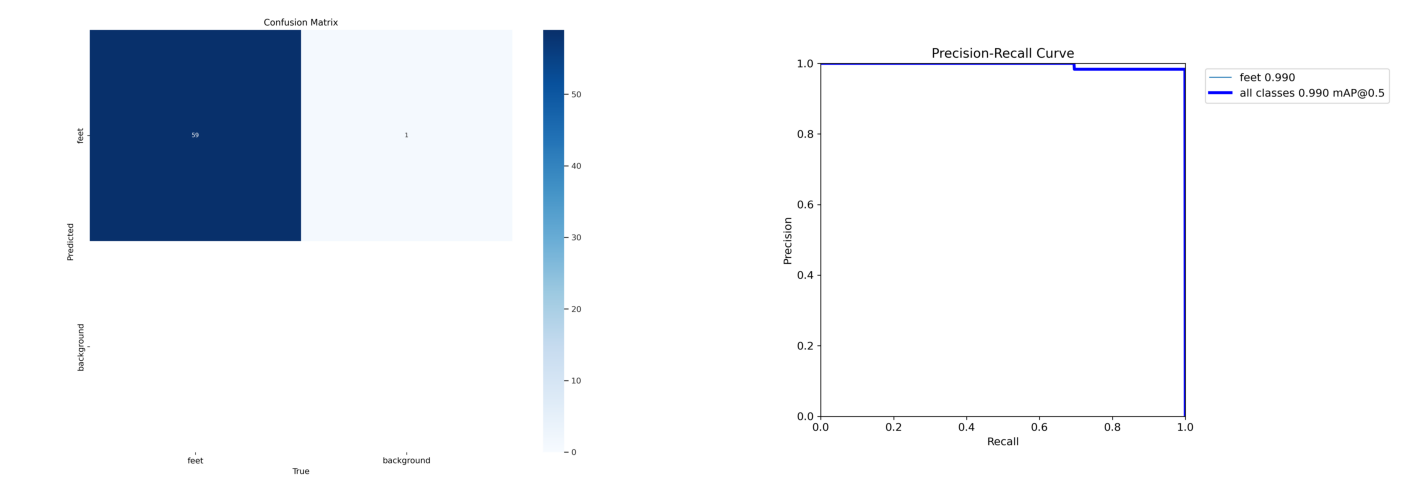

In [18]:
# Cargar la imagen
image = mpimg.imread("./runs/segment/val3/confusion_matrix.png")
image_1 = mpimg.imread("./runs/segment/val3/MaskPR_curve.png")

# Mostrar la matriz de confusión imagen
fig, axis = plt.subplots(1,2,figsize=(18,8))
axis[0].imshow(image)
axis[0].axis('off')
axis[1].imshow(image_1)
axis[1].axis('off')
plt.show()